In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test1', 'train', 'sampleSubmission.csv']


<h1>Code For Classification(CNN)</h1>
<div></div>
<h2>Introduction</h2>
* This Kernel for **image classification**.
* I use CNN for classification model.
* Reference learning [coursera.](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/lecture/G50oF/week-1-outro)




<h3>Module Importing</h3>

In [2]:
import numpy as np #numerical process
import pandas as pd  #dataframe
from keras.preprocessing.image import ImageDataGenerator, load_img #image utils
from keras.utils import to_categorical #categorical conversion
from sklearn.model_selection import train_test_split #test-train split
import matplotlib.pyplot as plt #visualization code
import random #random to select file randomly
import os #os utils
print(os.listdir("../input")) #files output

Using TensorFlow backend.


['test1', 'train', 'sampleSubmission.csv']


As we didnot define any framework to use keras uses tensorflow in backend and the files are **'train', 'sampleSubmission.csv', 'test1'**.
You can verify it by clicking on input folder of your kaggel kernel.

<h1>Required Utils</h1>

In [3]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

<h1>Prepareing Dataset</h1>
.
* We will use python modules to list our files.

In [4]:
files = os.listdir("../input/train/train")
classes = []
for file in files:
    clas = file.split('.')[0]
    if clas == 'dog':
        classes.append(1)
    else:
        classes.append(0)

df = pd.DataFrame({
    'file': files,
    'class': classes
})

In [5]:
df.head()

,file,class
0,cat.2944.jpg,0
1,dog.1112.jpg,1
2,cat.7212.jpg,0
3,dog.3679.jpg,1
4,cat.10191.jpg,0


what we have done here we have define that our classifier will see dog as 1 and cat as 0 . But this kind of approach will only be limited by classes if number of class increses it is not practical to use a method like this please use ImageGenerator as pointed in tensorflow to automate dataset generation. 

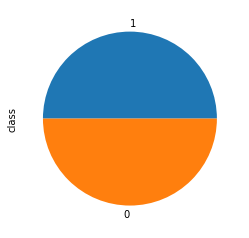

In [6]:

df['class'].value_counts().plot.pie()

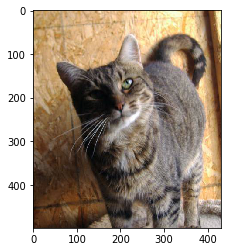

In [7]:

sample=random.choice(files)
image = load_img("../input/train/train/"+sample)
plt.imshow(image)
   
       


Number of total images

In [8]:
len(files)

25000

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 100x100 = 10000, it will convert to (10000,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

**Early Stop**
<div></div>
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**
<div></div>
We will reduce the learning rate when then accuracy not increase for 2 steps

**Callback**
<div></div>
We will callback training if accuracy reaches our estimates.

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

In [12]:
earlystop = EarlyStopping(patience=10)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
callbacks = myCallback()

In [16]:
callbacks = [earlystop, learning_rate_reduction,callbacks]

In [17]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'}) 

In [18]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [19]:
batch_size=15

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [21]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/train/train/", 
    x_col='file',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/train/train/", 
    x_col='file',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/train/train/", 
    x_col='file',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


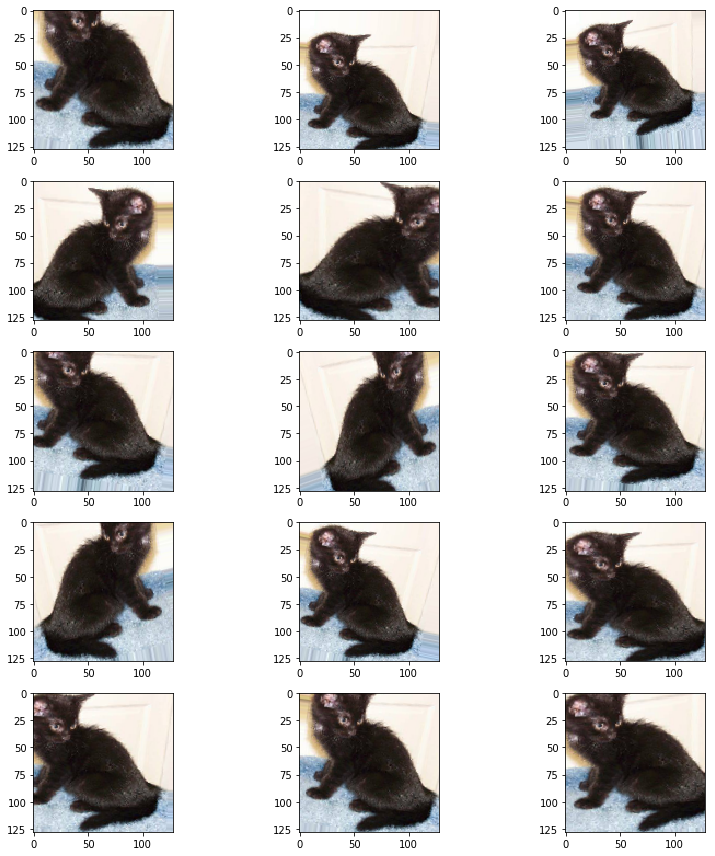

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
import time
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
start=time.time()
history = model.fit_generator(
    train_generator, 
    epochs=40,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
end=time.time()
print("training time {}".format(end-start))

Epoch 1/40
1333/1333 [==============================] - 208s 156ms/step - loss: 0.7317 - acc: 0.6395 - val_loss: 1.1602 - val_acc: 0.6090
Epoch 2/40
1333/1333 [==============================] - 158s 118ms/step - loss: 0.5392 - acc: 0.7322 - val_loss: 1.7150 - val_acc: 0.5348
Epoch 3/40
1333/1333 [==============================] - 159s 119ms/step - loss: 0.4525 - acc: 0.7883 - val_loss: 0.3494 - val_acc: 0.8526
Epoch 4/40
1333/1333 [==============================] - 158s 119ms/step - loss: 0.4151 - acc: 0.8141 - val_loss: 0.4570 - val_acc: 0.7866
Epoch 5/40
1333/1333 [==============================] - 160s 120ms/step - loss: 0.3847 - acc: 0.8274 - val_loss: 0.4398 - val_acc: 0.8098

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/40
1333/1333 [==============================] - 159s 119ms/step - loss: 0.3283 - acc: 0.8590 - val_loss: 0.2922 - val_acc: 0.8802
Epoch 7/40
1333/1333 [==============================] - 157s 118ms/step - loss: 0.3182 - ac

In [26]:
model.save_weights("model.h5")

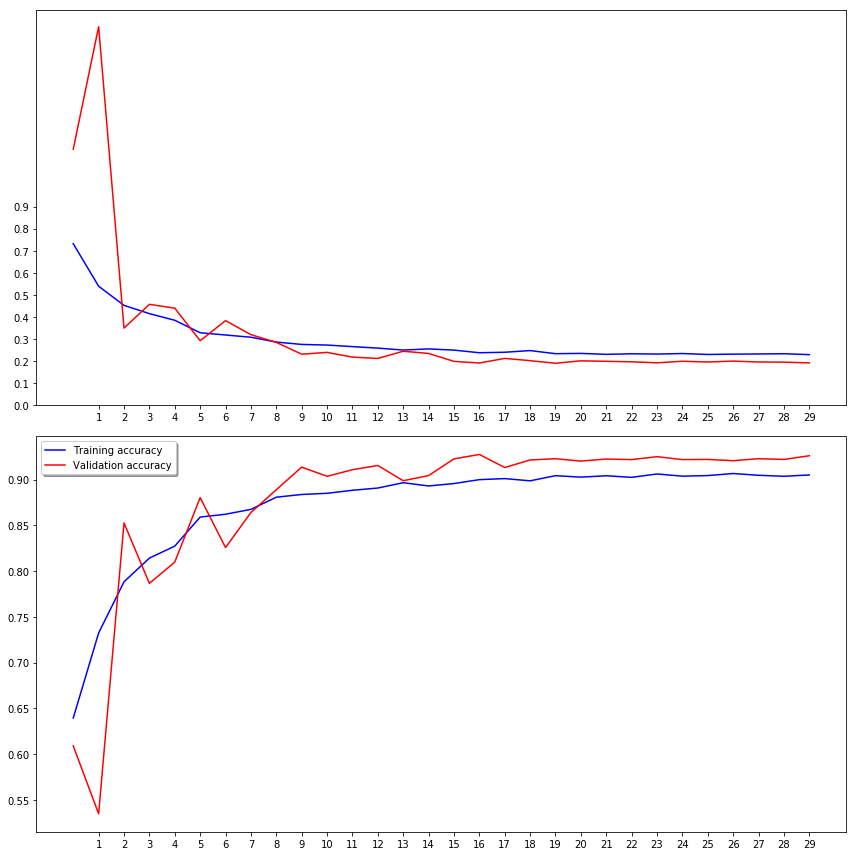

In [29]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [30]:
test_filenames = os.listdir("../input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [34]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [35]:
test_df['class'] = np.argmax(predict, axis=-1)

In [36]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['class'] = test_df['class'].replace(label_map)

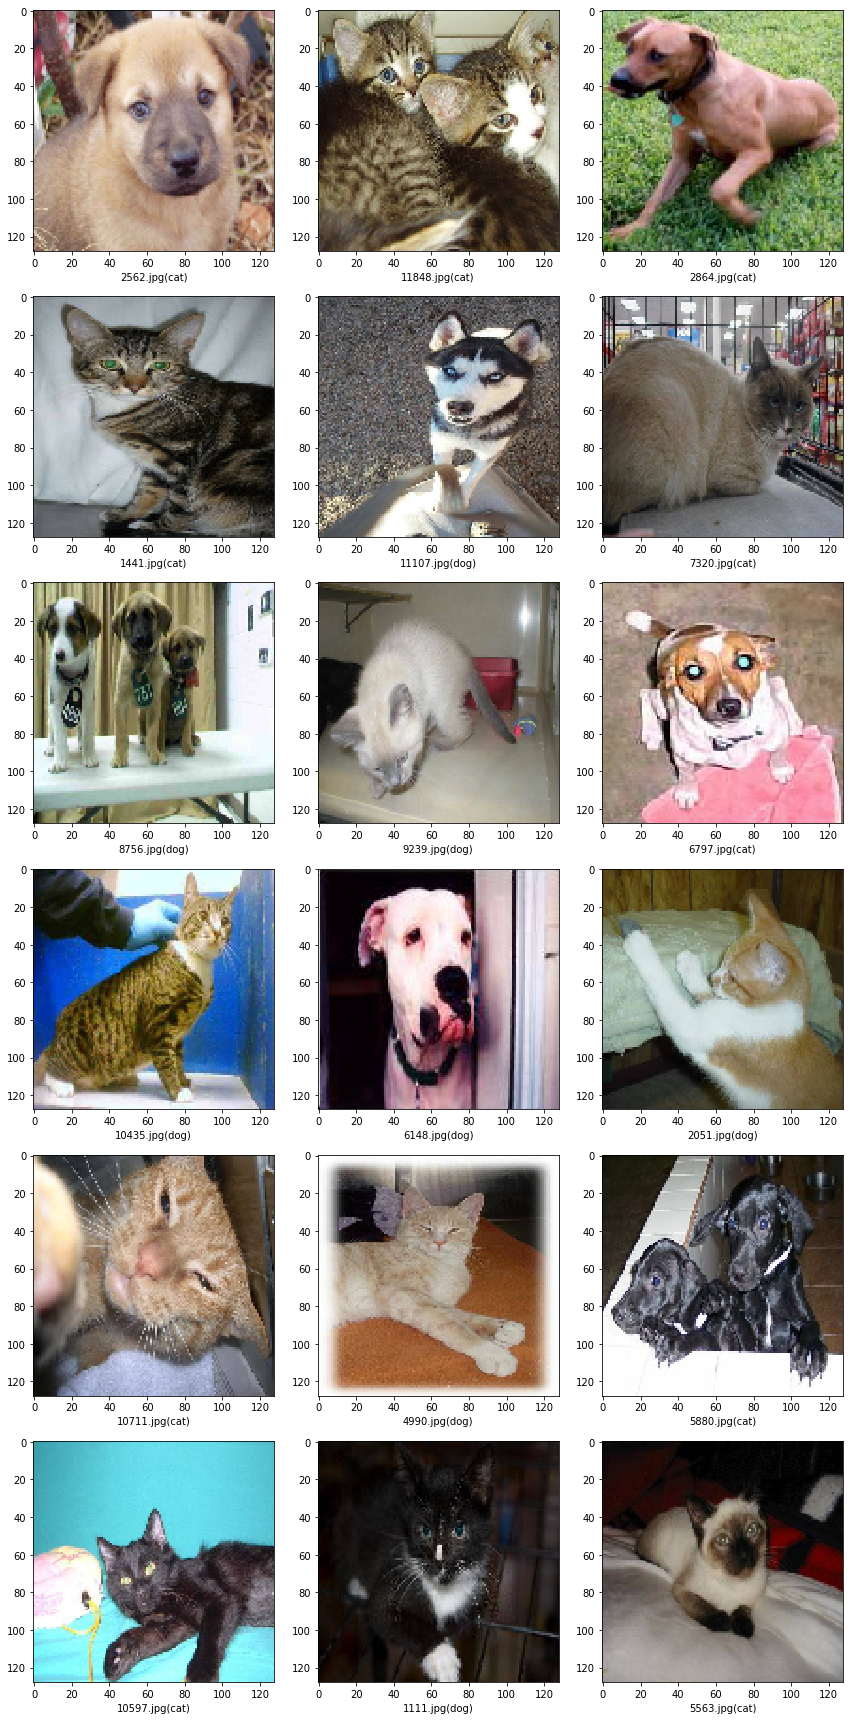

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['class']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [40]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['class']
submission_df.drop(['filename', 'class'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)